In [3]:
import pandas as pd

# Define the path to your dataset
file_path = '/Users/hananather/Desktop/Proactive_Disclosure_Grants/data.csv'


# Load the dataset in chunks
chunk_size = 10000  # Adjust the chunk size based on your memory capacity
chunks = pd.read_csv(file_path, chunksize=chunk_size)
# Alternatively, you can concatenate chunks into a single DataFrame
data = pd.concat(chunks)

# Perform operations on the entire DataFrame
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192000 entries, 0 to 191999
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ref_number                  192000 non-null  object 
 1   amendment_number            192000 non-null  int64  
 2   amendment_date              12716 non-null   object 
 3   agreement_type              191999 non-null  object 
 4   recipient_type              42132 non-null   object 
 5   recipient_business_number   26148 non-null   object 
 6   recipient_legal_name        192000 non-null  object 
 7   recipient_operating_name    4691 non-null    object 
 8   research_organization_name  13686 non-null   object 
 9   recipient_country           191954 non-null  object 
 10  recipient_province          145007 non-null  object 
 11  recipient_city              191989 non-null  object 
 12  recipient_postal_code       114986 non-null  object 
 13  federal_riding

In [5]:
import pandas as pd

# Define the path to your dataset
file_path = '/Users/hananather/Desktop/Proactive_Disclosure_Grants/data.csv'

# Load the dataset in chunks
chunk_size = 10000  # Adjust the chunk size based on your memory capacity
chunks = pd.read_csv(file_path, chunksize=chunk_size)

# Initialize an empty DataFrame to concatenate chunks
data = pd.DataFrame()

# Process each chunk
for chunk in chunks:
    # Perform operations on each chunk
    #print(chunk.head())  # For demonstration, print the first few rows of each chunk
    # Concatenate the chunk to the main DataFrame
    data = pd.concat([data, chunk], ignore_index=True)

# Perform operations on the entire DataFrame

# 1. Get the number of rows and columns
print(f"Total number of rows: {data.shape[0]}")
print(f"Total number of columns: {data.shape[1]}")

# 2. Get the summary statistics of the dataset
print("Summary statistics:")
print(data.describe(include='all'))

# 3. Identify and handle missing values
print("Missing values:")
print(data.isnull().sum())

# Example: Dropping rows with missing values
# data = data.dropna()

# 4. Analyze specific columns
# Example: Get unique values in a specific column (replace 'column_name' with the actual column name)
# unique_values = data['column_name'].unique()
# print(f"Unique values in 'column_name': {unique_values}")

# Example: Get the distribution of a specific column
# column_distribution = data['column_name'].value_counts()
# print(f"Distribution of 


Total number of rows: 192000
Total number of columns: 38
Summary statistics:
                    ref_number  amendment_number amendment_date  \
count                   192000     192000.000000          12716   
unique                  190103               NaN           3278   
top     235-2018-2019-Q2-00001               NaN     2020-04-23   
freq                         6               NaN            265   
mean                       NaN          0.053937            NaN   
std                        NaN          0.285350            NaN   
min                        NaN          0.000000            NaN   
25%                        NaN          0.000000            NaN   
50%                        NaN          0.000000            NaN   
75%                        NaN          0.000000            NaN   
max                        NaN          9.000000            NaN   

       agreement_type recipient_type recipient_business_number  \
count          191999          42132                

# Semantic Search
Semantic search seeks to improve search accuracy by understanding the semantic meaning of the search query and the corpus to search over. Semantic search can also perform well given synonyms, abbreviations, and misspellings, unlike keyword search. 

### Background
The idea behind semantic search is to embed all entries in our corpus, whether they be sentences, paragraphs, or documents, into a vector space. At search time, the query is embedding into the same vector space and the closest embeddings from the corpus are found. These entreis should have a high semantic similarity with query.

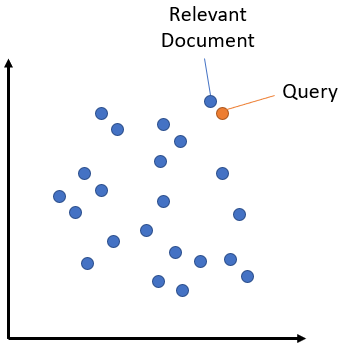


### Symmetric vs. Asymmetric Semantic Search

For **Symmetric semaintic search** the query and the entries in our corpus are about the same length and have the same amount fo content. 

For **asymmetric semantic search**, you usually have a **short query** (like a question or some keywords) and we want to find a longer paragraph answering the query


`sentence_transformer.util.semantic_search(query_embeddings: torch.tensor, corpus_embeddings: torch.Tensor, query_chunk_size:int, corpus_chunk_size:int, top_k: int, socore)`

### Speed Optimization
To get the optimal speed for `util.semantic_search` method,  it is advisable to have the `query_emebeddings` as well as the `corpus_embeddigs` on the same GPU device. This significantly boosts the performanc . 


### Approximate Nearest Neighbor

Searching a large corpus with millions of embeddings can be time-consuming if the exact nearest neighbor search is used. 

In that case, Approximate Nearest Neighbor (ANN) can be helpful. Here, the data can be partitioned into smaller fractions of similar embeddings. This index can be searched efficiently and embeddings with highest similarity (the nearest neighbors) can be retrived within milliseconds, even if we have millions of vectors. However, the results are not necessarily exact. It is possible that some vectors with high similarity will be missed. 

For ANN methods, there are usually one or more parameters to tune that determine the recall-speed tradeoff. If you want the highest speed, you have the chance of mising hits. If you want high recall, the search speed decreases. 


### Retrieve  & Re-rank

For complex semantic search scenarios, a two-stage retrive & re-rank pipeline is advisable:
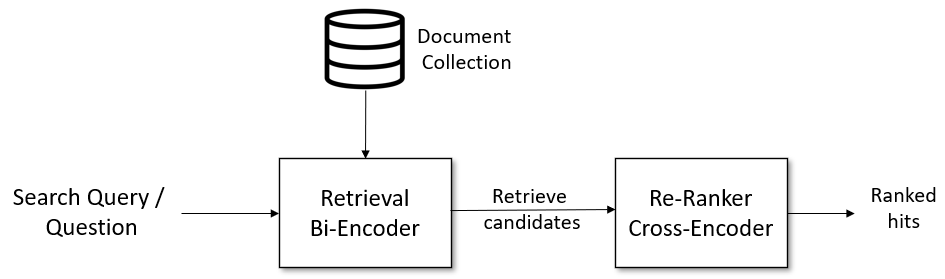

For the retrieval of the candiate set, we can use a bi-encoder which us implemented in Sentence Transfomers. Lexical search looks for literal matches of the query words in our document collection. It will not recognize synonyms, acronyms or spelling variations. In contrast, semantic search (or dense  retieval) encodes the search query into vector space and retrieves the document embeddings that are close in vector space. 

### Re-ranker: Cross-Encoder
The retriever has to be efficient for large document collections with millions of entries. However, it might return irrelevant candidates. A **re-ranker** based on a Cross-Encoder can substantially improve the final resutls for the users. The query and a possible document is passed simultaneously to transformer network, which then outputs a single score between 0 and 1 indicating how relevant the document is for a given query.
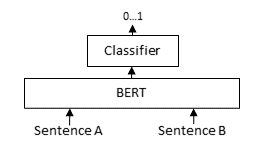

The advantage of Cross-Encoders is the higer performance, as they perform attention across the query and the document. Scoring thousands or millions of (query, document)-pairs would be rather slow. Hence, we use the retriever to create a set of 100 possible candidates which are re-ranked by the cross-encoder. 


###
Semantic search seeks to improve search accuracy by understanding the semantic meaning of the search query and the corpus to search over. Unlike keyword search, semantic search performs well given synonyms, abbreviations, and misspellings.


In [11]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load model
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

# Load a random sample of 1,000 records from the dataset
file_path = '/Users/hananather/Desktop/Proactive_Disclosure_Grants/data.csv'
data = pd.read_csv(file_path).sample(n=10000, random_state=42)

# Drop rows with missing descriptions
data.dropna(subset=['description_en', 'description_fr'], inplace=True)

# Embed descriptions
descriptions_en = data['description_en'].tolist()
descriptions_fr = data['description_fr'].tolist()

embeddings_en = model.encode(descriptions_en)
embeddings_fr = model.encode(descriptions_fr)

# Convert embeddings to float32
embeddings_en = np.array(embeddings_en).astype('float32')
embeddings_fr = np.array(embeddings_fr).astype('float32')

# Create FAISS index
d = model.get_sentence_embedding_dimension()  # Dimension of the embeddings
index_en = faiss.IndexFlatL2(d)  # L2 distance
index_fr = faiss.IndexFlatL2(d)  # L2 distance

# Add embeddings to the index
index_en.add(embeddings_en)
index_fr.add(embeddings_fr)

# Function to perform search
def search(query, top_k=5):
    query_embedding = model.encode([query]).astype('float32')
    distances_en, result_indices_en = index_en.search(query_embedding, top_k)
    distances_fr, result_indices_fr = index_fr.search(query_embedding, top_k)
    
    # Convert distances to similarity scores
    scores_en = 1 - distances_en[0] / np.max(distances_en[0])
    scores_fr = 1 - distances_fr[0] / np.max(distances_fr[0])
    
    return (result_indices_en[0], scores_en), (result_indices_fr[0], scores_fr)

# Perform a search
query = "research funding for environmental projects"
(results_indices_en, scores_en), (results_indices_fr, scores_fr) = search(query)

# Fetch the results from the data
results_en = data.iloc[results_indices_en]
results_fr = data.iloc[results_indices_fr]

# Add scores to the results
results_en['score'] = scores_en
results_fr['score'] = scores_fr

# Print the results
def print_results(results, lang):
    print(f"\n{lang} Results")
    for i, row in results.iterrows():
        print(f"Ref Number: {row['ref_number']}")
        print(f"Score: {row['score']:.2f}")
        print(f"Description: {row[f'description_{lang.lower()}']}\n")
        print("---")

print_results(results_en, "en")
print_results(results_fr, "fr")


/var/folders/ry/1ct1kks556s6ffsdyjq1grdh0000gn/T/ipykernel_1416/257743034.py:11: DtypeWarning: Columns (2,4,5,7,8,10,12,13,14,16,17,18,19,20,21,22,24,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path).sample(n=10000, random_state=42)



en Results
Ref Number: 276-2011-2012-Q1-00231
Score: 0.17
Description: Hire environmental science project manager

---
Ref Number: 276-2023-2024-Q3-00091
Score: 0.06
Description: Support business and community engagement on major green energy projects

---
Ref Number: 236-2014-2015-Q4-00238
Score: 0.02
Description: MD/PhD Program Grant (starting 2014-15)

---
Ref Number: 276-2008-2009-Q1-00287
Score: 0.01
Description: Funding for young entrepreneur development initiative

---
Ref Number: 276-2019-2020-Q2-00082
Score: 0.00
Description: Support research and innovation in key priority areas

---

fr Results
Ref Number: 236-2014-2015-Q4-00238
Score: 0.13
Description: MD/PhD Program Grant (starting 2014-15)

---
Ref Number: 236-2013-2014-Q3-00004
Score: 0.10
Description: MD/PhD Program Grant (starting in 2013-14)

---
Ref Number: 236-2013-2014-Q3-00103
Score: 0.10
Description: MD/PhD Program Grant (starting in 2013-14)

---
Ref Number: 236-2011-2012-Q4-00399
Score: 0.10
Description: MD/PhD

/var/folders/ry/1ct1kks556s6ffsdyjq1grdh0000gn/T/ipykernel_1416/257743034.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_en['score'] = scores_en
/var/folders/ry/1ct1kks556s6ffsdyjq1grdh0000gn/T/ipykernel_1416/257743034.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_fr['score'] = scores_fr


In [15]:
import numpy as np
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load model
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

# Load a random sample of 1,000 records from the dataset
file_path = '/Users/hananather/Desktop/Proactive_Disclosure_Grants/data.csv'
data = pd.read_csv(file_path).sample(n=10000, random_state=42)
# Drop rows with missing descriptions
data.dropna(subset=['description_en', 'description_fr'], inplace=True)
data

/var/folders/ry/1ct1kks556s6ffsdyjq1grdh0000gn/T/ipykernel_1416/2345942876.py:10: DtypeWarning: Columns (2,4,5,7,8,10,12,13,14,16,17,18,19,20,21,22,24,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path).sample(n=10000, random_state=42)


,ref_number,amendment_number,amendment_date,agreement_type,recipient_type,recipient_business_number,recipient_legal_name,recipient_operating_name,research_organization_name,recipient_country,...,coverage,description_en,description_fr,naics_identifier,expected_results_en,expected_results_fr,additional_information_en,additional_information_fr,owner_org,owner_org_title
35422,276-2018-2019-Q2-00452,2,2020-11-24,C,NaN,NaN,iHub Learning Inc.|iHub Learning Inc.,NaN,NaN,CA,...,NaN,Support the establishment of the Innovation Hu...,Soutenir la création du centre d’innovation (i...,NaN,NaN,NaN,The grant or contribution awarded has been ame...,La subvention ou contribution octroyée a été m...,acoa-apeca,Atlantic Canada Opportunities Agency | Agence ...
38670,276-2021-2022-Q4-00650,0,NaN,C,NaN,107772790,Newfoundland & Labrador Oil & Gas Industries A...,NaN,NaN,CA,...,NaN,International business workshops and networkin...,"Organiser ateliers commerce international, rés...",81391.0,NaN,NaN,The assistance type is Non-Repayable Contribut...,Le type d'aide est contribution non remboursable.,acoa-apeca,Atlantic Canada Opportunities Agency | Agence ...
152684,016-2021-2022-Q4-11259,0,NaN,G,NaN,NaN,Evelyn Walsh,NaN,NaN,CA,...,NaN,Athlete Assistance Program,Programme d’aide aux athlètes,NaN,Canadian athletes receive financial support in...,Les athlètes canadiens reçoivent pour appui fi...,NaN,NaN,pch,Canadian Heritage | Patrimoine canadien
13870,235-2023-2024-Q4-00084,0,NaN,C,F,815848650,Nature Canneberge Inc.,NaN,NaN,CA,...,NaN,This project aims to purchase electrically-dri...,Ce projet vise à l'achat de pompes d’eau à mot...,11133,To advance agricultural clean technologies wit...,Faire progresser les technologies propres en a...,NaN,NaN,aafc-aac,Agriculture and Agri-Food Canada | Agriculture...
136799,016-2020-2021-Q4-31178,0,NaN,G,NaN,NaN,Matthew Debly,NaN,NaN,CA,...,NaN,Athlete Assistance Program,Programme d’aide aux athlètes,NaN,1. Canadian athletes receive the financial sup...,1. Les athlètes canadiens reçoivent le soutien...,NaN,NaN,pch,Canadian Heritage | Patrimoine canadien
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111941,016-2018-2019-Q4-1322767,0,NaN,G,NaN,NaN,BATUKI MUSIC SOCIETY INC.,NaN,NaN,CA,...,NaN,Building Communities Through Arts and Heritage,Développement des communautés par le biais des...,NaN,The Local Arts and Heritage Festivals componen...,Le volet Festivals des arts locaux et du patri...,NaN,NaN,pch,Canadian Heritage | Patrimoine canadien
154010,016-2022-2023-Q2-1351531,0,NaN,G,NaN,NaN,VIEUX THEATRE DE ST-FABIEN (LE),NaN,NaN,CA,...,NaN,Canada Arts Presentation Fund - CAPF - Budget ...,Fonds du Canada pour la présentation des arts ...,NaN,NaN,NaN,NaN,NaN,pch,Canadian Heritage | Patrimoine canadien
168583,016-2023-2024-Q3-1362132,0,NaN,G,NaN,NaN,HAMLET OF CAMBRIDGE BAY,NaN,NaN,CA,...,NaN,Building Communities Through Arts and Heritage...,Développement des communautés par le biais des...,NaN,The Local Arts and Heritage Festivals componen...,"Promouvoir le multiculturalisme, la diversité,...",NaN,NaN,pch,Canadian Heritage | Patrimoine canadien
53377,093-2020-2021-Q4-00081,0,2021-01-15,C,F,811876606,9240-0282 Québec inc. - Café Van Houtte|9240-0...,NaN,NaN,CA,...,NaN,Working Capital: In the context of the crisis ...,Fonds de roulement : Dans le contexte de la cr...,NaN,Communities are economically diversified in Qu...,Les collectivités sont économiquement diversif...,Contingently Recoverable Contribution,Contribution remboursable conditionnelle,ced-dec,Canada Economic Development for Quebec Regions...


In [17]:
# Embed descriptions
descriptions_en = data['description_en'].tolist()
descriptions_fr = data['description_fr'].tolist()

embeddings_en = model.encode(descriptions_en, convert_to_tensor=True)
embeddings_fr = model.encode(descriptions_fr, convert_to_tensor=True)


# Define search topics
topics = ["Youth employment", "LGBTQ", "visible minorities", "Indigenous peoples"]

# Function to perform search
def search(query, top_k=10):
    query_embedding = model.encode([query], convert_to_tensor=True)
    results_en = util.semantic_search(query_embedding, embeddings_en, top_k=top_k)
    results_fr = util.semantic_search(query_embedding, embeddings_fr, top_k=top_k)
    return results_en[0], results_fr[0]

# Function to get results with scores
def get_results_with_scores(results, data):
    indices = [result['corpus_id'] for result in results]
    scores = [result['score'] for result in results]
    result_data = data.iloc[indices].copy()
    result_data['score'] = scores
    return result_data

# Function to print results
def print_results(results, lang):
    print(f"\n{lang} Results")
    for i, row in results.iterrows():
        print(f"Ref Number: {row['ref_number']}")
        print(f"Score: {row['score']:.2f}")
        print(f"Description: {row[f'description_{lang}']}\n")
        print("---")

# Perform searches and display results for each topic
for topic in topics:
    print(f"\nSearch results for topic: {topic}")
    results_en, results_fr = search(topic)

    results_en_df = get_results_with_scores(results_en, data)
    results_fr_df = get_results_with_scores(results_fr, data)

    print_results(results_en_df, "en")
    print_results(results_fr_df, "fr")


Search results for topic: Youth employment

en Results
Ref Number: 276-2006-2007-Q3-00203
Score: 0.66
Description: Implement a youth engagement strategy

---
Ref Number: 276-2008-2009-Q1-00296
Score: 0.65
Description: Youth entrepreneurship 2008/09

---
Ref Number: 236-2016-2017-Q1-00051
Score: 0.64
Description: TYDE:  Transitioning Youth with Disabilities and Employment

---
Ref Number: 276-2016-2017-Q2-00501
Score: 0.63
Description: Renovate the youth centre

---
Ref Number: 016-2019-2020-Q4-1328097
Score: 0.63
Description: Youth Take Charge

---
Ref Number: 016-2022-2023-Q1-1346635
Score: 0.63
Description: Youth Take Charge

---
Ref Number: 016-2019-2020-Q4-1328098
Score: 0.63
Description: Youth Take Charge

---
Ref Number: 016-2019-2020-Q2-1322303
Score: 0.63
Description: Youth Take Charge

---
Ref Number: 016-2022-2023-Q1-1346477
Score: 0.63
Description: Youth Take Charge

---
Ref Number: 016-2018-2019-Q4-1322300
Score: 0.63
Description: Youth Take Charge

---

fr Results
Ref Num